# Build and test a Nearest Neighbors classifier.

Load the relevant packages.

In [242]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import numpy as np
from sklearn.datasets import load_iris

In [243]:
# not allowed, but let's try it
from scipy import spatial

Load the Iris data to use for experiments. The data include 50 observations of each of 3 types of irises (150 total). Each observation includes 4 measurements: sepal and petal width and height. The goal is to predict the iris type from these measurements.

<http://en.wikipedia.org/wiki/Iris_flower_data_set>

# 1. load the data and check what's in it

In [244]:
# Load the data, which is included in sklearn.
iris = load_iris()

In [245]:
type(iris)

sklearn.utils.Bunch

In [246]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [247]:
print('Iris target names:', iris.target_names)
print('Iris feature names:', iris.feature_names)

Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [248]:
type(iris.data)

numpy.ndarray

In [249]:
iris.data.shape

(150, 4)

In [250]:
iris.data[1:10]

array([[4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

In [251]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [252]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [253]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

# 2. Shuffle and assigning to test and train sets

In [254]:
# assigns to X and Y for easier referencing
X, Y = iris.data, iris.target
print(X.shape)
print(Y.shape)

(150, 4)
(150,)


In [255]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]
print(X.shape)
print(Y.shape)

(150, 4)
(150,)


In [256]:
# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(100, 4)
(100,)
(50, 4)
(50,)


# 3. Create our own distance functions for fun and profit

Create a distance function that returns the distance between 2 observations.

In [257]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

In [258]:
def EuclideanDistance2(v1, v2):
    return spatial.distance.euclidean(v1, v2)

In [259]:
def EuclideanDistance3(v1, v2):
    ew = np.vstack((v1, v2)).transpose()
    ss = sum(map(lambda x: (x[0] - x[1]) ** 2, ew))
    return ss ** 0.5

In [260]:
EuclideanDistance(train_data[0], train_data[1])

1.889444362769118

In [261]:
EuclideanDistance2(train_data[0], train_data[1])

1.889444362769118

In [262]:
EuclideanDistance3(train_data[0], train_data[1])

1.889444362769118

Just for fun, let's compute all the pairwise distances in the training data and plot a histogram.

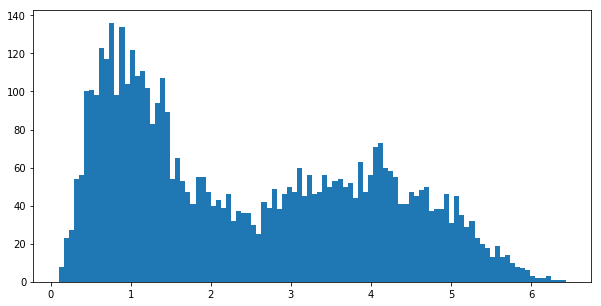

In [263]:
dists = []
for i in range(len(train_data) - 1):
    for j in range(i + 1, len(train_data)):
        #dist = EuclideanDistance(train_data[i], train_data[j])
        #dist = EuclideanDistance2(train_data[i], train_data[j])
        dist = EuclideanDistance3(train_data[i], train_data[j])
        dists.append(dist)
        
fig = plt.hist(dists, 100)

# 4. Our 1-Nearest Neighbors classifier

Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

<http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier>

In [264]:
class NearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance):
        self.metric = metric
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        best_dist, best_label = 1.0e10, None
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            if dist < best_dist:
                best_label = self.train_labels[i]
                best_dist = dist
        return best_label

Run an experiment with the classifier.

In [265]:
clf = NearestNeighbors()
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  48  accuracy: 0.96


# 5. Our k-Nearest Neighbors classifier

The implementation above only allows for a single nearest neighbor; that is, the classifier predicts the label of the closest available point. What about using more than one nearest neighbor. Typically, this means to make a prediciton we:

1. Find the k closest points (according to our distance metric) to the query point.
2. Find the majority label of those k points found in (1)
3. Return the label in (2) as the prediction

In [272]:
class OurKNearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance, k=5):
        self.metric = metric
        self.k = k
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
        return results
    
    # Private function for making a single prediction using KNN.
    def _predict_item(self, item):
        '''for a single item, we want to:
                compute distance between item and all other train data
                find the 5 nearest neighbors, and get their labels
                calculate the best label, by simple majority vote
        '''
        # gets the distance from self.item to each training item, 
        # by mapping the distance function over the set of training data
        vd = list(map(lambda x: EuclideanDistance3(item, x), self.train_data))
        # gets the indices, and the labels, of the closest k neighbors 
        lbls = self.train_labels[np.argsort(vd)[1:self.k+1]]
        # gets the counts and proportions per class
        unique, counts = np.unique(lbls, return_counts=True)
        lbls_dict = dict(zip(unique, counts))
        # returns the best label based on max vote
        # note, this doesn't handle ties well
        best_label = [ky for ky, vl in lbls_dict.items() if vl == max(lbls_dict.values())]
        best_label = best_label[0]
        return best_label

# 6. Picking k: the number of neighbors to use in classification

If you did not do the above, you can use sklearn's nearest neighbors classifier for an implementation with multiple k

Implement a way to pick the number of neighbors to use in the classifier. We already have a test set, so simply extend the procedure in the previous code cell to run over different numbers of neighbors. Plot the test set performance versus the number of neighbors.

(note: you can use sklearn's implementation here; for a challenge, implement knn above [only 1-nn is implemented right now!])

In [275]:
# using Our KNN classifier

clf = OurKNearestNeighbors(k=5)
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  48  accuracy: 0.96


In [276]:
# using the sklearn KNN classifier
# https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)

# we already have encoded labels, and our features are already numeric
# so we don't need the encode step
model.fit(train_data,train_labels)

preds = model.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  48  accuracy: 0.96


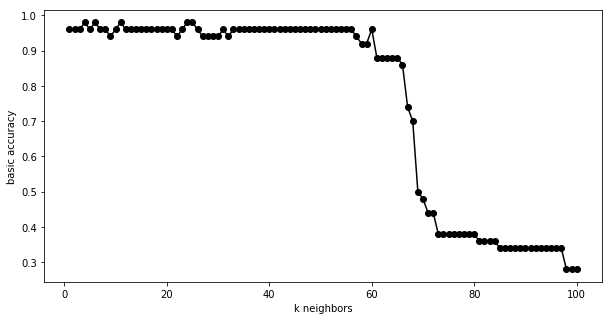

In [277]:
# ok so can we systematically vary the k and plot the performance?
# assuming sklearn
from sklearn.neighbors import KNeighborsClassifier

# helper functiont that returns the accuracy
# re-uses a bunch of code from before
def apply_knn(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data,train_labels)
    preds = model.predict(test_data)
    correct, total = 0, 0
    for pred, label in zip(preds, test_labels):
        if pred == label: correct += 1
        total += 1
    return 1.0*correct/total

# maps the apply knn function over array of 1 to 100, to get the basic accuracy per k
ks = np.arange(1, len(train_data) + 1)
ksa = list(map(apply_knn, ks))

# plots the k and basic accuracy
plt.plot(ks, ksa, '-o', color='black')
plt.xlabel('k neighbors')
plt.ylabel('basic accuracy')
plt.show()

# 7. Visualizing the results

We've been a litte haphazard so far, we should have plotted the data and some results to get an idea of how the algorithm is performing. Plot the data with the true labels as colors, and plot it with some predicted labels as colors, for differing values of k, to see how our KNN algorithm is performing.

(50, 4)


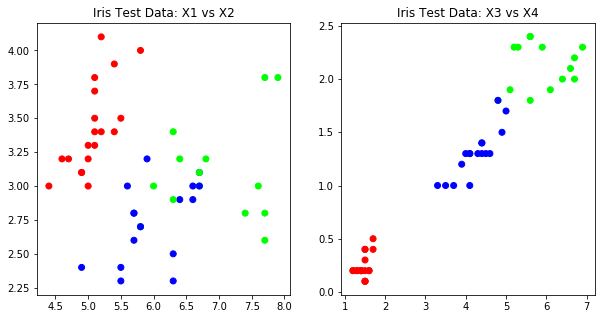

In [278]:
print(test_data.shape)

#### YOUR CODE HERE

cm_bright = ListedColormap(['#FF0000', '#0000FF', '#00FF00'])
p = plt.subplot(1, 2, 1)
p.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=cm_bright)
plt.title("Iris Test Data: X1 vs X2")

p = plt.subplot(1, 2, 2)
p.scatter(test_data[:, 2], test_data[:, 3], c=test_labels, cmap=cm_bright)
plt.title("Iris Test Data: X3 vs X4")
plt.show()

#### YOUR CODE HERE 


### A different distance metric

We used the euclidean distance metric, try implementing another one. A couple of suggestions:

1. L1 (manhattan) distance
2. Lp distance ( https://en.wikipedia.org/wiki/Lp_space )
3. L-infinity distance
4. Try a metric that re-weights by dimension index, e.g. discard one dimension entirely

Do any of these improve or greatly affect the results? (Use the test set to back up any statements)

In [ ]:
#### YOUR CODE HERE

# a reminder of what euclidean distance looks like
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5